In [1]:
import pandas as pd
import cvxpy as cp
import mosek
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
import random
from scipy.integrate import cumtrapz

parameters to change
1. red (thus green) light duration
2. max speed
3. max accel
4. max braking

In [2]:
# powertrain constant to define

## Shared across platforms

m = 1611+82             # average vehicle mass + driver [kg]
rho = 1.225             # air density [kg/m^3]
Cd = 0.23               # drag coefficient
Aref = 2.22             # average vehicle frontal area [m^2]
g = 9.81                # gravity constant [m/s^2]
Crr = 0.01              # rolling resistance coefficient
Cv = 0.3                # kinetic friction coefficient
r = 0.334               # wheel radius [m] (235/45R18 tire)

## ICE only (Honda Civic 2012 5AT)
f_ice = 0.375           # idle fuel consumption [ml/s]
P_max = 104.398         # max engine power [kw]
P_min = 0               # min engine power [kw]
wp_max = 6500           # engine angular speed at max power [rpm]
wt_max = 4300           # engine angular speed at max torque [rpm]
gear = [2.666, 1.534, 1.022, 0.721, 0.525, 4.44] # gear ratio
cor_v = [0, 7.5, 11.4, 16, 22] # corresponding velocity for each gear(ex: gear 1 ratio = 2.666,cor_v = 0~7.5) [m/s]

## EV only
# f_ev =                # idle energy consumption[kW]
capacity_kWh = 54       # [kWh]
Voc = 360               # [V]
Pmax_kW = 211           # [kW]
Tmax_Nm = 375           # [Nm]
Tmax_rpm = 4000         # [rpm] max motor speed at max torque
gear_ratio = 9          # motor to driven axle gear ratio
max_speed = 16000       # [rpm] maximum motor speed
dt_eff = 0.85           # drivetrain efficiency
Rcirc = 0.05            # [Ohms]

# constraint constants to define

pos_final = 2000        # corridor horizon [m]
N = 380                 # time horizon [sec]
vel_lower = 0           # velocity lower bound [m/s]
vel_upper = 17.5        # velocity upper bound [m/s]
acc_abs = 1.5           # accel upper bound [m/s^2]
jerk_abs = 1            # jerk (derivative of acceleration) upper bound [m/s^3]
lin_drag = 10           # linearize drag about this speed

# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]

N = 380 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5

In [10]:
vel_upper_lst = [50, 45, 40, 35, 30] # [mph]
acc_abs_lst = [1, 2, 3, 4, 5] # [m/s^2]
redlight_lst = [60, 50, 40, 30, 20] # [s]

In [4]:
def set_up(vel_upper=vel_upper, acc_abs=acc_abs, redlight=redlight):
    
    
    # Define optimization vars

    x1 = cp.Variable(N+1) # Position
    x2 = cp.Variable(N+1) # Velocity
    T = cp.Variable(N) # Powertrain torque
    Fdrag = cp.Variable(N) # Vehicle drag
    E = cp.Variable(N+1) # Battery energy
    Pmot = cp.Variable(N) # Battery power
    Vcirc = cp.Variable(N) # Circuit voltage
    I = cp.Variable(N) # Motor current
    SOC = cp.Variable(N+1) # Battery SOC

    # Define objective function
    objective = cp.Minimize( E[0]-E[N] ); title = 'Minimum Energy' # Minimum energy
    # objective = cp.Minimize(-x1@np.ones(N+1) + (E[0]-E[N])); title = 'Minimum Time' # Minimum time - Lower N until solver fails for guaranteed minimum time

    # Define constraints
    constraints = [ ] 
    constraints += [ x1[0] == 0 ] # pos_init = 0 m
    constraints += [ x1[N] == pos_final ] # pos_final = 1000 m
    constraints += [ x2[0] == 0 ] # vel_init = 0 m/s
    constraints += [ x2[N] == 0 ] # vel_final = 0 m/s
    constraints += [ x2[1] == x2[0] ] # # acc_init = 0 m/s^2
    constraints += [ x2[N] == x2[N-1] ] # acc_final = 0 m/s^2
    
    # Traffic light constraints
    # Define a traffic light as [initial time, final time, position]

    tls = []
    for intersection in np.arange(0, pos_final, block):
        for start in np.arange(10, N*dt, redlight + greenlight):
            tls.append([start, start + redlight, intersection]) # + random.randint(-5, 5)

    tls_bools = {}
    tls_on = True # Control whether or not traffic lights are used
    # The for loop below will automatically create constraints for all traffic lights
    for i in range(len(tls)):
        # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N and tls_on:            
            dict_index = "tl{0}".format(i)
            tls_bools[dict_index] = cp.Variable(1, boolean=True)
            # Clip end of traffic light if it goes past optimization horizon
            t_initial = int(tls[i][0]/dt)
            if int(tls[i][1]/dt) > N:
                t_final = N
            else:
                t_final = int(tls[i][1]/dt)
            position = tls[i][2]
            constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
            constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

    for k in range(0,N):
        
        constraints += [ x2[k+1] >= vel_lower ] # vel_lower >= 0 m/s
        constraints += [ x2[k+1] <= vel_upper ] # vel_lower <= 15 m/s (~55 km/hr)
        constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ] # acc_lower >= -3 m/s^2
        constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ] # acc_upper <= 3 m/s^2
        constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
        constraints += [ x2[k+1] == x2[k] + ( (T[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
        constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2[k]**2 + Cv*x2[k] + Crr*m*g ]
        constraints += [ E[k+1] == E[k] - Voc*Vcirc[k]/Rcirc*dt/3600 ]
        constraints += [ x2[k]*60/(2*np.pi*r)*gear_ratio <= 10000 ]
        constraints += [ T[k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed + (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
        constraints += [ T[k] >= - Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]

    # SOC
    constraints += [ SOC[0] == 0.8 ]
    constraints += [ SOC == E/capacity_kWh/1000]
    constraints += [ SOC <= 0.8 ]
    constraints += [ SOC >= 0.2 ]
    # Power
    constraints += [ Pmot <= Vcirc/Rcirc*Voc - (Vcirc)**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
    constraints += [ T <= Tmax_Nm ]
    constraints += [ T >= -Tmax_Nm ]
    constraints += [ T == Pmot/(Pmax_kW*1000)*Tmax_Nm ]
    # Voc
    constraints += [ Vcirc/Rcirc <= (Pmax_kW*1000)/Voc ] # Current limit

    for k in range(1, N):
        # Minimize jerk (derivative of acceleration)
        constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
        constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]
    

    prob = cp.Problem(objective, constraints)
    prob.solve(solver='MOSEK')

    E_regen = np.zeros(N+1)
    for i in range(1,len(E_regen)):
        if Vcirc.value[i-1] < 0:
            E_regen[i] = E_regen[i-1] - Voc*Vcirc.value[i-1]/Rcirc*dt/3600
        else:
            E_regen[i] = E_regen[i-1]
    
    var_dict = {
        
        'x1': x1.value,
        'x2': x2.value,
        'T': T.value,
        'Fdrag': Fdrag.value,
        'E': E.value,
        'Pmot': Pmot.value,
        'Vcirc': Vcirc.value,
        'I': I.value,
        'SOC': SOC.value,
        'regen': E_regen
        
    }
    
    return objective, constraints, var_dict

In [5]:
def optimizer_loop(vel_upper_lst=[vel_upper], acc_abs_lst=[acc_abs], redlight_lst=[redlight]):
    
    pos = []
    vel = []
    soc = []
    regen = []
    
    tic_glob = time.perf_counter() 
    
    for vel_upper in vel_upper_lst:
        
        vel_upper_ms = vel_upper * 0.44704
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(vel_upper=vel_upper_ms)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        
        
        print(f"====== Solving with vel_upper = {vel_upper} mph : {toc - tic:0.3f} seconds ======")

    print("")
    for acc_abs in acc_abs_lst:
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(acc_abs=acc_abs)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        
        print(f"====== Solving with acc_abs = {acc_abs} m/s2 : {toc - tic:0.3f} seconds ======")
    
    print("")
    for redlight in redlight_lst:
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(redlight=redlight)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
    
        print(f"====== Solving with redlight = {redlight} s : {toc - tic:0.3f} seconds ======")
        
    toc_glob = time.perf_counter()
    
    print("")
    print(f"Loop complete")
    print(f"Time used = : {toc_glob - tic_glob:0.3f} seconds")
    
    return pos, vel, soc, regen

In [11]:
# 
import time
pos_rst, vel_rst, soc_rst, regen_rst = optimizer_loop(vel_upper_lst=vel_upper_lst, 
                                                     acc_abs_lst=acc_abs_lst,
                                                     redlight_lst=redlight_lst)

====== Solving with vel_upper = 50 mph : 12.470 seconds ======
====== Solving with vel_upper = 45 mph : 12.013 seconds ======
====== Solving with vel_upper = 40 mph : 12.029 seconds ======
====== Solving with vel_upper = 35 mph : 12.498 seconds ======
====== Solving with vel_upper = 30 mph : 11.881 seconds ======

====== Solving with acc_abs = 1 m/s2 : 11.619 seconds ======
====== Solving with acc_abs = 2 m/s2 : 12.195 seconds ======
====== Solving with acc_abs = 3 m/s2 : 12.838 seconds ======
====== Solving with acc_abs = 4 m/s2 : 11.445 seconds ======
====== Solving with acc_abs = 5 m/s2 : 11.841 seconds ======

====== Solving with redlight = 60 s : 11.454 seconds ======
====== Solving with redlight = 50 s : 11.936 seconds ======
====== Solving with redlight = 40 s : 11.091 seconds ======
====== Solving with redlight = 30 s : 12.764 seconds ======
====== Solving with redlight = 20 s : 11.828 seconds ======

Loop complete
Time used = : 179.902 seconds


In [12]:
tls = []
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection])

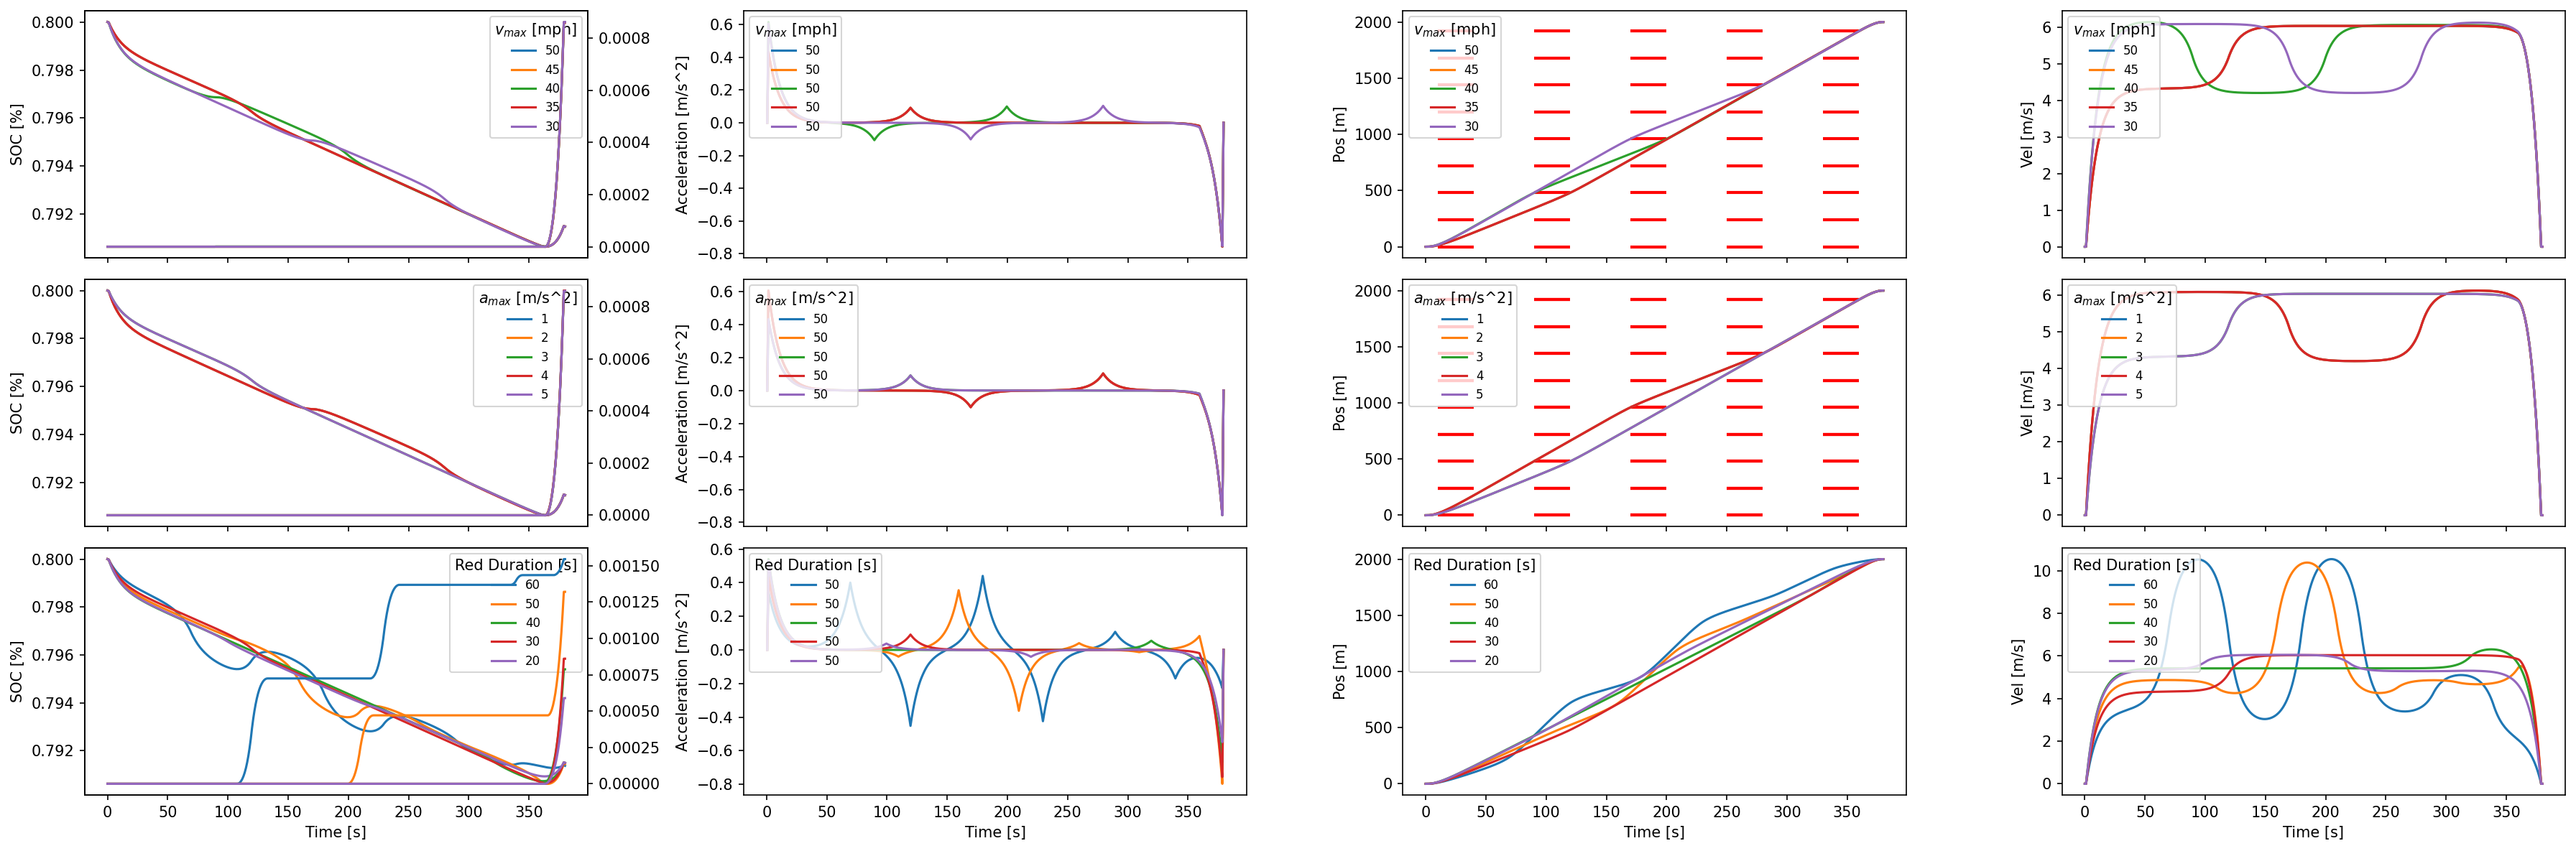

In [13]:
time = np.arange(0, (N+1)*dt, dt)

fig, axs = plt.subplots(3, 4, figsize=(24, 8), sharex=True)
legend_font = 8

plt_soc = 0
plt_acc = 1
plt_x1 = 2
plt_x2 = 3

row_vel = 0
row_acc = 1
row_red = 2

# row 1: altering v_max ===================================================
axs[row_vel][plt_soc].plot(time, soc_rst[0], label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_soc].plot(time, soc_rst[1], label=f'{vel_upper_lst[1]}')
axs[row_vel][plt_soc].plot(time, soc_rst[2], label=f'{vel_upper_lst[2]}')
axs[row_vel][plt_soc].plot(time, soc_rst[3], label=f'{vel_upper_lst[3]}')
axs[row_vel][plt_soc].plot(time, soc_rst[4], label=f'{vel_upper_lst[4]}')
axs[row_vel][plt_soc].set_ylabel('SOC [%]')
axs[row_vel][plt_soc].legend(title=r'$v_{max}$ [mph]', loc='upper right', fontsize=legend_font)

ax_twin = axs[row_vel][plt_soc].twinx()
ax_twin.plot(time, regen_rst[0]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[1]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[2]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[3]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[4]/(capacity_kWh*1000))


axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[0][1:]-vel_rst[0][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[1][1:]-vel_rst[1][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[2][1:]-vel_rst[2][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[3][1:]-vel_rst[3][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[4][1:]-vel_rst[4][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[row_vel][plt_acc].legend(title=r'$v_{max}$ [mph]', loc='upper left', fontsize=legend_font)


axs[row_vel][plt_x1].plot(time, pos_rst[0], label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_x1].plot(time, pos_rst[1], label=f'{vel_upper_lst[1]}')
axs[row_vel][plt_x1].plot(time, pos_rst[2], label=f'{vel_upper_lst[2]}')
axs[row_vel][plt_x1].plot(time, pos_rst[3], label=f'{vel_upper_lst[3]}')
axs[row_vel][plt_x1].plot(time, pos_rst[4], label=f'{vel_upper_lst[4]}')
axs[row_vel][plt_x1].set_ylabel('Pos [m]')
axs[row_vel][plt_x1].legend(title=r'$v_{max}$ [mph]', loc='upper left', fontsize=legend_font)

for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N:
        axs[row_vel][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[row_vel][plt_x2].plot(time, vel_rst[0], label=f'{vel_upper_lst[0]}')
axs[row_vel][plt_x2].plot(time, vel_rst[1], label=f'{vel_upper_lst[1]}')
axs[row_vel][plt_x2].plot(time, vel_rst[2], label=f'{vel_upper_lst[2]}')
axs[row_vel][plt_x2].plot(time, vel_rst[3], label=f'{vel_upper_lst[3]}')
axs[row_vel][plt_x2].plot(time, vel_rst[4], label=f'{vel_upper_lst[4]}')
axs[row_vel][plt_x2].set_ylabel('Vel [m/s]')
axs[row_vel][plt_x2].legend(title=r'$v_{max}$ [mph]', loc='upper left', fontsize=legend_font)

# row 2: altering acc_max ================================================
axs[row_acc][plt_soc].plot(time, soc_rst[5], label=f'{acc_abs_lst[0]}')
axs[row_acc][plt_soc].plot(time, soc_rst[6], label=f'{acc_abs_lst[1]}')
axs[row_acc][plt_soc].plot(time, soc_rst[7], label=f'{acc_abs_lst[2]}')
axs[row_acc][plt_soc].plot(time, soc_rst[8], label=f'{acc_abs_lst[3]}')
axs[row_acc][plt_soc].plot(time, soc_rst[9], label=f'{acc_abs_lst[4]}')
axs[row_acc][plt_soc].set_ylabel('SOC [%]')
axs[row_acc][plt_soc].legend(title=r'$a_{max}$ [m/s^2]', loc='upper right', fontsize=legend_font)
ax_twin = axs[row_acc][plt_soc].twinx()
ax_twin.plot(time, regen_rst[5]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[6]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[7]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[8]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[9]/(capacity_kWh*1000))

axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[5][1:]-vel_rst[5][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[6][1:]-vel_rst[6][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[7][1:]-vel_rst[7][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[8][1:]-vel_rst[8][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[9][1:]-vel_rst[9][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_acc][plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[row_acc][plt_acc].legend(title=r'$a_{max}$ [m/s^2]', loc='upper left', fontsize=legend_font)

axs[row_acc][plt_x1].plot(time, pos_rst[5], label=f'{acc_abs_lst[0]}')
axs[row_acc][plt_x1].plot(time, pos_rst[6], label=f'{acc_abs_lst[1]}')
axs[row_acc][plt_x1].plot(time, pos_rst[7], label=f'{acc_abs_lst[2]}')
axs[row_acc][plt_x1].plot(time, pos_rst[8], label=f'{acc_abs_lst[3]}')
axs[row_acc][plt_x1].plot(time, pos_rst[9], label=f'{acc_abs_lst[4]}')
axs[row_acc][plt_x1].set_ylabel('Pos [m]')
axs[row_acc][plt_x1].legend(title=r'$a_{max}$ [m/s^2]', loc='upper left', fontsize=legend_font)

for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N:
        axs[row_acc][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[row_acc][plt_x2].plot(time, vel_rst[5], label=f'{acc_abs_lst[0]}')
axs[row_acc][plt_x2].plot(time, vel_rst[6], label=f'{acc_abs_lst[1]}')
axs[row_acc][plt_x2].plot(time, vel_rst[7], label=f'{acc_abs_lst[2]}')
axs[row_acc][plt_x2].plot(time, vel_rst[8], label=f'{acc_abs_lst[3]}')
axs[row_acc][plt_x2].plot(time, vel_rst[9], label=f'{acc_abs_lst[4]}')
axs[row_acc][plt_x2].set_ylabel('Vel [m/s]')
axs[row_acc][plt_x2].legend(title=r'$a_{max}$ [m/s^2]', loc='upper left', fontsize=legend_font)


# row 3: altering red_light duration ====================================
axs[row_red][plt_soc].plot(time, soc_rst[10], label=f'{redlight_lst[0]}')
axs[row_red][plt_soc].plot(time, soc_rst[11], label=f'{redlight_lst[1]}')
axs[row_red][plt_soc].plot(time, soc_rst[12], label=f'{redlight_lst[2]}')
axs[row_red][plt_soc].plot(time, soc_rst[13], label=f'{redlight_lst[3]}')
axs[row_red][plt_soc].plot(time, soc_rst[14], label=f'{redlight_lst[4]}')
axs[row_red][plt_soc].set_ylabel('SOC [%]')
axs[row_red][plt_soc].legend(title=r'Red Duration [s]', loc='upper right', fontsize=legend_font)
axs[row_red][plt_soc].set_xlabel('Time [s]')
ax_twin = axs[row_red][plt_soc].twinx()
ax_twin.plot(time, regen_rst[10]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[11]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[12]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[13]/(capacity_kWh*1000))
ax_twin.plot(time, regen_rst[14]/(capacity_kWh*1000))

axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[10][1:]-vel_rst[10][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[11][1:]-vel_rst[11][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[12][1:]-vel_rst[12][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[13][1:]-vel_rst[13][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[14][1:]-vel_rst[14][:-1])/dt, label=f'{vel_upper_lst[0]}')
axs[row_red][plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[row_red][plt_acc].legend(title=r'Red Duration [s]', loc='upper left', fontsize=legend_font)
axs[row_red][plt_acc].set_xlabel('Time [s]')

axs[row_red][plt_x1].plot(time, pos_rst[10], label=f'{redlight_lst[0]}')
axs[row_red][plt_x1].plot(time, pos_rst[11], label=f'{redlight_lst[1]}')
axs[row_red][plt_x1].plot(time, pos_rst[12], label=f'{redlight_lst[2]}')
axs[row_red][plt_x1].plot(time, pos_rst[13], label=f'{redlight_lst[3]}')
axs[row_red][plt_x1].plot(time, pos_rst[14], label=f'{redlight_lst[4]}')
axs[row_red][plt_x1].set_ylabel('Pos [m]')
axs[row_red][plt_x1].legend(title=r'Red Duration [s]', loc='upper left', fontsize=legend_font)
axs[row_red][plt_x1].set_xlabel('Time [s]')

for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N:
        axs[row_acc][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[row_red][plt_x2].plot(time, vel_rst[10], label=f'{redlight_lst[0]}')
axs[row_red][plt_x2].plot(time, vel_rst[11], label=f'{redlight_lst[1]}')
axs[row_red][plt_x2].plot(time, vel_rst[12], label=f'{redlight_lst[2]}')
axs[row_red][plt_x2].plot(time, vel_rst[13], label=f'{redlight_lst[3]}')
axs[row_red][plt_x2].plot(time, vel_rst[14], label=f'{redlight_lst[4]}')
axs[row_red][plt_x2].set_ylabel('Vel [m/s]')
axs[row_red][plt_x2].legend(title=r'Red Duration [s]', loc='upper left', fontsize=legend_font)
axs[row_red][plt_x2].set_xlabel('Time [s]')

plt.tight_layout()
# plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

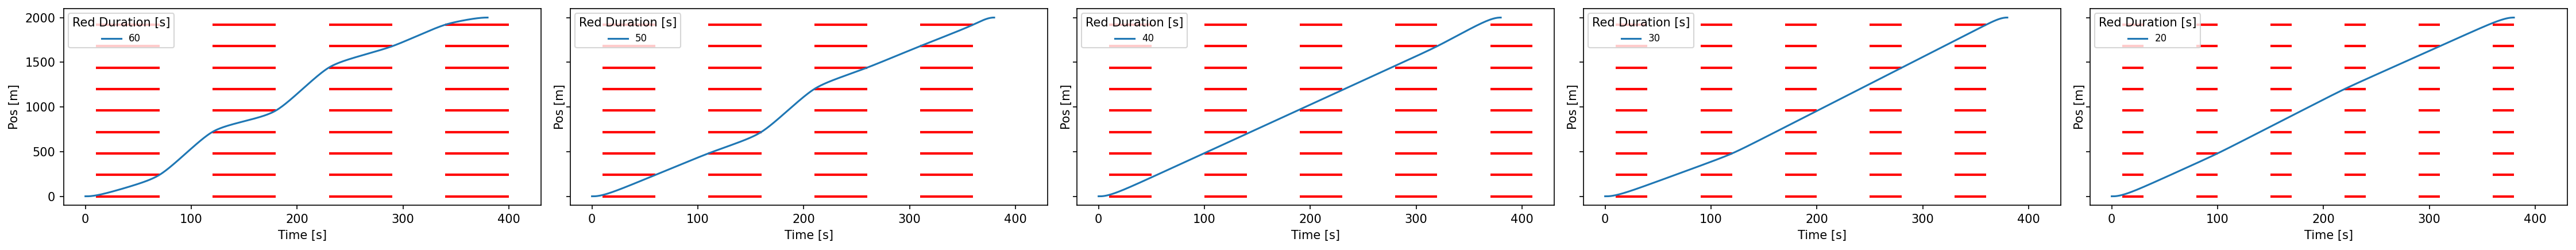

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(30, 3), sharex=True, sharey=True)

for i in np.arange(5):
    pos_index = 10 + i
    redlight = redlight_lst[i]
    
    axs[i].plot(time, pos_rst[pos_index], label=f'{redlight_lst[i]}')
    axs[i].set_ylabel('Pos [m]')
    axs[i].legend(title=r'Red Duration [s]', loc='upper left', fontsize=legend_font)
    axs[i].set_xlabel('Time [s]')
    
    tls = []
    for intersection in np.arange(0, pos_final, block):
        for start in np.arange(10, N*dt, redlight + greenlight):
            tls.append([start, start + redlight, intersection])
            
    for j in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
        if int(tls[j][0]/dt) <= N:
            axs[i].hlines(y=tls[j][2], xmin=tls[j][0], xmax=tls[j][1], linewidth=2, color='r')
    

plt.tight_layout()
plt.show()